# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

BUFFER_SIZE = int(1e5)    # replay buffer size
BATCH_SIZE   = 64         # minibatch size
GAMMA        = 0.90       # discount factor
TAU          = 0.03       # for soft update of target parameters
UPDATE_EVERY = 4          # how often to update the network

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device  = 'cpu'

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, number_hidden_unit, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, number_hidden_unit)
        self.fc2 = nn.Linear(number_hidden_unit, number_hidden_unit)
        self.fc3 = nn.Linear(number_hidden_unit, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, number_hidden_unit, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self._state_size = state_size
        self._action_size = action_size
        self._number_hidden_unit = number_hidden_unit
        self._seed = random.seed(seed)

        # Q-Network
        """Double Q-Learning uses Q-network-1 (qnetwork_local) to select actions and Q-network-2 (qnetwork_target) to evaluate the selected actions."""
        self.qnetwork_local  = QNetwork(self._state_size, self._action_size, self._number_hidden_unit, seed)
        self.qnetwork_target = QNetwork(self._state_size, self._action_size, self._number_hidden_unit, seed)

        self.qnetwork_local.fc1.bias.data.fill_(0)
        self.qnetwork_local.fc1.weight.data.normal_(std=0.01)
        self.qnetwork_local.fc2.bias.data.fill_(0)
        self.qnetwork_local.fc2.weight.data.normal_(std=0.01)
        self.qnetwork_local.fc3.bias.data.fill_(0)
        self.qnetwork_local.fc3.weight.data.normal_(std=0.01)
        
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        
        self.qnetwork_local.to(device)
        self.qnetwork_target.to(device)        

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=0.001)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, lr_value, lr_active):
        # Save experience in replay memory
        
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA, lr_value, lr_active)

    def act(self, state, epsilon):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # converting state (numpy representation) to tensor and expnading the dimension by adding a new dimension at the start
        # State is a vector with shape (dim). So, Using .unsqueeze(0) makes it (1,dim)
        # Every time we convert numpy to tensor, we need to send the tensor to the device
        state = (torch.from_numpy(state)).float().unsqueeze(0).to(device)  
        self.qnetwork_local.train(mode=False)
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train(mode=True)

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            # Numpy cannot handle GPU tensors. So, we need to make them CPU tensors first using cpu() and then convert into numpy
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self._action_size)) 

    def learn(self, experiences, gamma, lr_value, lr_active):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states      = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)


        # Get max predicted Q values (for next states) from target model
        # Max(dimension:0 for column and 1 for rows) operation returns [values,indicies]. So, get first column for values setting the output of shape (dim). So, Using .unsqueeze(1) makes it (dim,1)
        # Here we are evaluating the action using the Bellman equation (R + Gamma*Max(Q)) and hence we use the second QNetwork (target network)
        Q_targets_next = self.qnetwork_target(next_states).max(1)[0].unsqueeze(1)
        Q_targets_next = Q_targets_next.detach()
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        # gather function collects values along an axis specified as follows father(which axis: 0 for column and 1 for row, which indicies:represnted here by action numbers)
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        # Clear the gradients, do this because gradients are accumulated
        self.optimizer.zero_grad()
        if(lr_active == 0):
            self.optimizer.lr = lr_value

        # Forward pass, then loss, then backward pass, then update weights
        # We are not doing forward pass since we have already done it and calculated the loss
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_((1.0-tau)*target_param.data + tau*local_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.appendleft(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        return experiences       
  
        

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [7]:
state = env_info.vector_observations[0]
state_size_env = len(state)
action_size_env = brain.vector_action_space_size
agent = Agent(state_size_env, action_size_env, 64, 151)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [8]:
def dqn(n_episodes,fixed):
    """Deep Q-Learning.
    1-epsilon : probability of selecting greedy action
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    eps_start = 1.0
    eps_end   = 0.01
    eps_decay = 0.995
    min_lr    = 0.001
    
    max_lr=0.1
    scores = []                        # list containing scores from each episode
    Epsilon_All = []
    LR_All      = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    if(fixed == 1):
        adam_lr = 0.001
    else:
        adam_lr = max_lr 
    for i_episode in range(1, n_episodes+1):
        Epsilon_All.append(eps)
        LR_All.append(adam_lr)
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done = False
        while not done:
            action     = agent.act(state, eps)
            Next_info  = env.step(action)[brain_name]        # send the action to the environment
            next_state = Next_info.vector_observations[0]   # get the next state
            reward     = Next_info.rewards[0]                   # get the reward
            done       = Next_info.local_done[0]                  # see if episode has finished
    
            agent.step(state, action, reward, next_state, done, adam_lr, fixed)
            state = next_state
            score += reward
        if(fixed == 0):
            last_lr = agent.optimizer.lr   
        last_lr = adam_lr
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        #eps     = max(eps_end, eps_start - (eps_start - eps_end) * (i_episode/n_episodes)) # decrease epsilon
        if(fixed == 0):
            adam_lr = max(min_lr , max_lr - (max_lr-min_lr) * (i_episode/n_episodes))
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.3f}\tLR: {:.3f}'.format(i_episode, np.mean(scores_window),eps,last_lr), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'Double_DQN_Tau003.pth')
            break
    return scores, Epsilon_All, LR_All



In [9]:
score, epsilon, LR = dqn(2000,1)

Episode 10	Average Score: 0.20	Epsilon: 0.951	LR: 0.001
Episode 20	Average Score: 0.30	Epsilon: 0.905	LR: 0.001
Episode 30	Average Score: 0.60	Epsilon: 0.860	LR: 0.001
Episode 40	Average Score: 0.72	Epsilon: 0.818	LR: 0.001
Episode 50	Average Score: 0.88	Epsilon: 0.778	LR: 0.001
Episode 60	Average Score: 1.02	Epsilon: 0.740	LR: 0.001
Episode 70	Average Score: 1.29	Epsilon: 0.704	LR: 0.001
Episode 80	Average Score: 1.35	Epsilon: 0.670	LR: 0.001
Episode 90	Average Score: 1.54	Epsilon: 0.637	LR: 0.001
Episode 100	Average Score: 1.76	Epsilon: 0.606	LR: 0.001
Episode 110	Average Score: 2.19	Epsilon: 0.576	LR: 0.001
Episode 120	Average Score: 2.53	Epsilon: 0.548	LR: 0.001
Episode 130	Average Score: 2.96	Epsilon: 0.521	LR: 0.001
Episode 140	Average Score: 3.25	Epsilon: 0.496	LR: 0.001
Episode 150	Average Score: 3.61	Epsilon: 0.471	LR: 0.001
Episode 160	Average Score: 3.88	Epsilon: 0.448	LR: 0.001
Episode 170	Average Score: 4.31	Epsilon: 0.427	LR: 0.001
Episode 180	Average Score: 4.84	Epsilon:

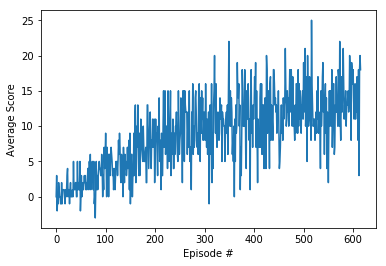

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score)), score)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 